In [455]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest
from itertools import combinations

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

## Fase 1: Exploración y Limpieza

#### 1. Exploración Inicial:

Realiza una exploración inicial de los datos para identificar posibles problemas, como valores nulos, atípicos o datos faltantes en las columnas relevantes.

Utiliza funciones de Pandas para obtener información sobre la estructura de los datos, la presencia de valores nulos y estadísticas básicas de las columnas involucradas.

Une los dos conjuntos de datos de la forma más eficiente.

## CSV 1

In [456]:
# Leer CSV 1
df1 = pd.read_csv("Files/Customer Flight Activity.csv")
# Ver las 5 primeras filas
df1.head()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


In [457]:
# Ver las ultimas 5 filas
df1.tail()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
405619,999902,2018,12,0,0,0,0,0.0,0,0
405620,999911,2018,12,0,0,0,0,0.0,0,0
405621,999940,2018,12,3,0,3,1233,123.0,0,0
405622,999982,2018,12,0,0,0,0,0.0,0,0
405623,999986,2018,12,0,0,0,0,0.0,0,0


In [458]:
# Cambiamos los nombres de las columnas al español 
columnas_traducidas = {
    'Loyalty Number': 'numero_cliente',
    'Year': 'ano',
    'Month': 'mes',
    'Flights Booked': 'vuelos_reservados',
    'Flights with Companions': 'vuelos_con_acompanantes',
    'Total Flights': 'total_vuelos',
    'Distance': 'distancia',
    'Points Accumulated': 'puntos_acumulados',
    'Points Redeemed': 'puntos_canjeados',
    'Dollar Cost Points Redeemed': 'costo_en_dolares_de_los_puntos_canjeados'
}
df1.rename(columns= columnas_traducidas, inplace=True)

In [459]:
# Vemos la forma
df1.shape

(405624, 10)

Vemos que inicialmente tenemos 405624 filas y 10 columnas

In [460]:
# Informacion del df
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   numero_cliente                            405624 non-null  int64  
 1   ano                                       405624 non-null  int64  
 2   mes                                       405624 non-null  int64  
 3   vuelos_reservados                         405624 non-null  int64  
 4   vuelos_con_acompanantes                   405624 non-null  int64  
 5   total_vuelos                              405624 non-null  int64  
 6   distancia                                 405624 non-null  int64  
 7   puntos_acumulados                         405624 non-null  float64
 8   puntos_canjeados                          405624 non-null  int64  
 9   costo_en_dolares_de_los_puntos_canjeados  405624 non-null  int64  
dtypes: float64(1), int64

Todos los datos son númericos. -->  Se valorará cambiar la columna año y mes a formato fecha.

In [461]:
# Sumamos los nulos por columnas
df1.isna().sum()

numero_cliente                              0
ano                                         0
mes                                         0
vuelos_reservados                           0
vuelos_con_acompanantes                     0
total_vuelos                                0
distancia                                   0
puntos_acumulados                           0
puntos_canjeados                            0
costo_en_dolares_de_los_puntos_canjeados    0
dtype: int64

No hay nulos en ninguna columna 

In [462]:
# calculamos estadisticos de las variables numericas
df1.describe()

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
count,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000
mean,550037.873084,2017.500000,6.500000,4.115052,1.031805,5.146858,1208.880059,123.692721,30.696872,2.484503
std,258935.286969,0.500001,3.452057,5.225518,2.076869,6.521227,1433.155320,146.599831,125.486049,10.150038
min,100018.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326961.000000,2017.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550834.000000,2017.500000,6.500000,1.000000,0.000000,1.000000,488.000000,50.000000,0.000000,0.000000
75%,772194.000000,2018.000000,9.250000,8.000000,1.000000,10.000000,2336.000000,239.000000,0.000000,0.000000
max,999986.000000,2018.000000,12.000000,21.000000,11.000000,32.000000,6293.000000,676.500000,876.000000,71.000000


Podemos ver que los datos son desde de enero del 2017 a diciembre del 2018.

Vemos valores atipicos que pueden estar afectando a las medias.Hay una desviacion estandar alta.

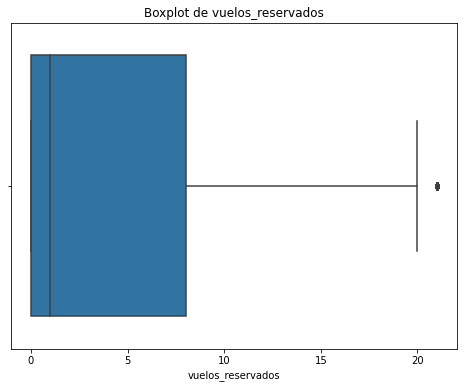

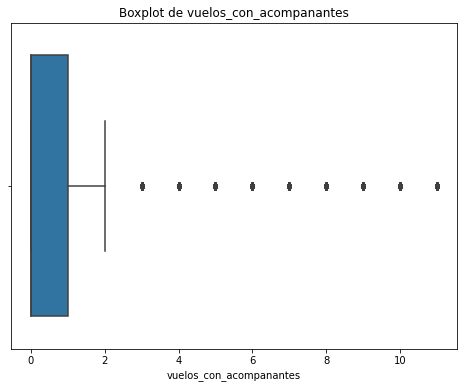

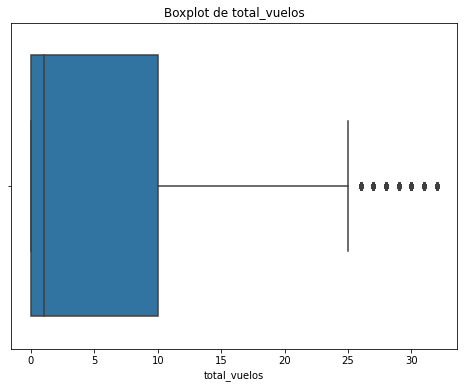

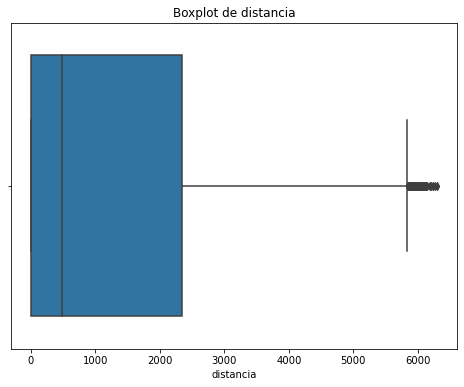

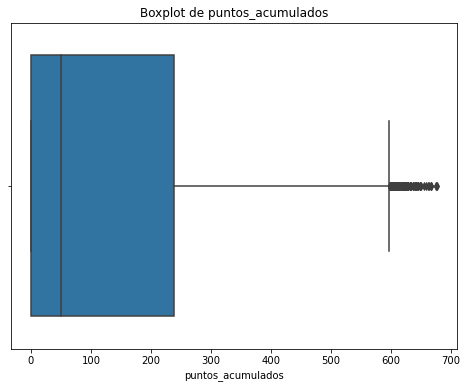

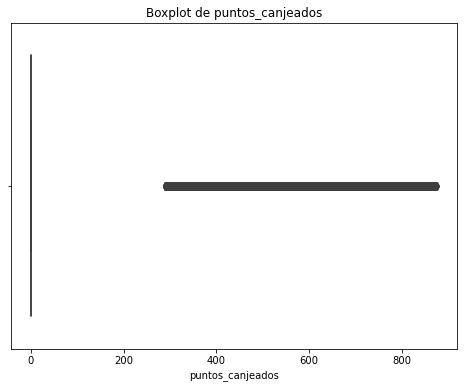

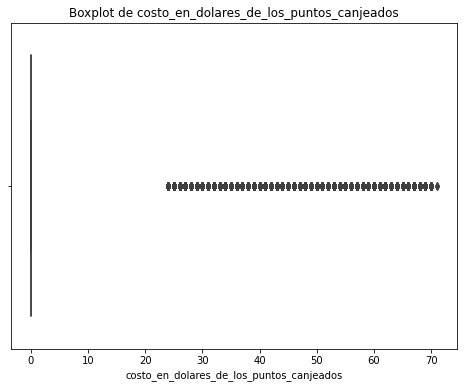

In [463]:
# vemos la distribucion en graficas
for columna in df1.iloc[:,3:]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df1[columna])
    plt.title(f'Boxplot de {columna}')
    plt.xlabel(columna)
    plt.show()

In [464]:
# sumamos filas duplicadas
df1.duplicated().sum()

1864

Tenemos valores duplicados en las filas, vamos a verlos para decidir que hacer con ellos

In [465]:
# cuantos numeros de clientes tenemos unicos
df1["numero_cliente"].nunique()

16737

16737 valores unicos de clientes

In [466]:
# vamos a ver todos los duplicados ordenando por numero cliente, año y mes
df1[df1.duplicated(keep=False)].sort_values(by=["numero_cliente", "ano", "mes"]).head(15)

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
41,101902,2017,1,0,0,0,0,0.0,0,0
42,101902,2017,1,0,0,0,0,0.0,0,0
16942,101902,2017,2,0,0,0,0,0.0,0,0
16943,101902,2017,2,0,0,0,0,0.0,0,0
33843,101902,2017,3,0,0,0,0,0.0,0,0
33844,101902,2017,3,0,0,0,0,0.0,0,0
101447,101902,2017,7,0,0,0,0,0.0,0,0
101448,101902,2017,7,0,0,0,0,0.0,0,0
185952,101902,2017,12,0,0,0,0,0.0,0,0
185953,101902,2017,12,0,0,0,0,0.0,0,0


Hay clientes con duplicados cuando no viaja

In [467]:
#  vemos que pasa con ese cliente
df1.sort_values(by=["numero_cliente", "ano", "mes"]).iloc[984:999,:]

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
41,101902,2017,1,0,0,0,0,0.0,0,0
42,101902,2017,1,0,0,0,0,0.0,0,0
16942,101902,2017,2,0,0,0,0,0.0,0,0
16943,101902,2017,2,0,0,0,0,0.0,0,0
33843,101902,2017,3,0,0,0,0,0.0,0,0
33844,101902,2017,3,0,0,0,0,0.0,0,0
50744,101902,2017,4,4,0,4,1460,146.0,0,0
185796,101902,2017,4,4,4,8,2384,238.0,488,40
67645,101902,2017,5,9,3,12,2748,274.0,0,0
67646,101902,2017,5,7,0,7,3318,331.0,0,0


Algo raro, cuando el cliente no viaja genera filas por mes y por año vacias pero por otro lado hay dos filas por meses pero con numero de vuelos reservados por lo que entiendo que seran reservas realizadas en dias del mes distinto. Cuadno el cliente solo realiza un vaije por mes no pasa esto. Habria que profundizar más. 

Decido no borrar las columnas duplicadas por si el cliente ha reservado el mismo numero de vuelos el mismo ano y mes  pero distinto dia

In [468]:
# Numeros de cliente duplicados
df1["numero_cliente"].duplicated().sum()

388887

Tenemos duplicados en la columna de numero de cliente debido a que el mismo cliente hace varios viajes. 

Como antes vimos en las graficas valores atipicos en costo en dolares vamos a entenderlo

In [469]:
# df con gasto
df_con_gasto = df1[df1["costo_en_dolares_de_los_puntos_canjeados"]!=0]
df_con_gasto.sample()

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
374751,937662,2017,4,2,2,4,556,55.0,491,40


In [470]:
# ver el porcentaje de dolares distintos de 0
df1[df1["costo_en_dolares_de_los_puntos_canjeados"]!=0].shape[0]/df1.shape[0]*100

5.961432262390785

In [471]:
# ver el porcentaje de dolares igual 0
df1[df1["costo_en_dolares_de_los_puntos_canjeados"]==0].shape[0]/df1.shape[0]*100

94.03856773760921

Cerca del 6% realiza coste canjando puntos 

El 94% no causa coste canjeando puntos

In [472]:
# estadistico variables numericas
df_con_gasto["costo_en_dolares_de_los_puntos_canjeados"].describe()

count    24181.000000
mean        41.676275
std          9.736304
min         24.000000
25%         34.000000
50%         41.000000
75%         48.000000
max         71.000000
Name: costo_en_dolares_de_los_puntos_canjeados, dtype: float64

Text(0.5, 1.0, 'Coste $ de los puntos canjeados')

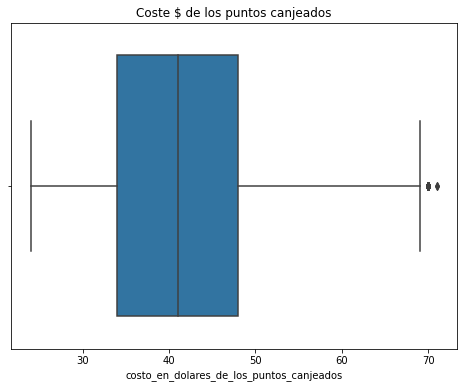

In [473]:
# lo vemos en grafica
plt.figure(figsize=(8, 6)) 
sns.boxplot(x = df_con_gasto["costo_en_dolares_de_los_puntos_canjeados"]);
plt.title(f"Coste $ de los puntos canjeados") 

Esto ya nos deja ver cual es el coste de la gente que canjea puntos. Vamos a comprobar pero debe de estar relacionado con los puntos canjeados

Text(0.5, 1.0, 'Coste $ de los puntos canjeados')

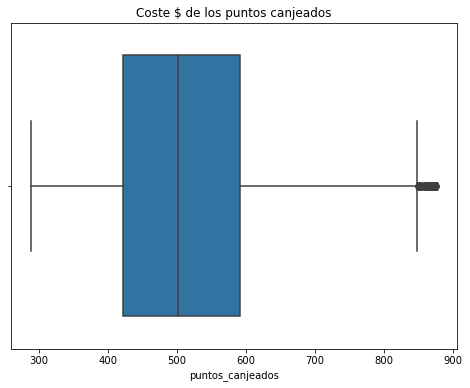

In [474]:
# lo mismo para puntos
plt.figure(figsize=(8, 6))
sns.boxplot(x= df_con_gasto["puntos_canjeados"]);
plt.title(f"Coste $ de los puntos canjeados")


Efectivamente parece que esta relacionado 

### Correlaciones

In [475]:
# sacamos las columnas numericas (en este df todas)
numericas = df1.select_dtypes(include = np.number).columns
# las combinamos
combinaciones = list(combinations(numericas, 2))

In [476]:
# creamos una función para identificar si las relaciones entre las variables son lienales o no
def identificar_linealidad (dataframe, lista_combinacion_columnas):
    """
    Identifica si las relaciones entre pares de variables en un DataFrame son lineales o no.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        El DataFrame que contiene las variables a analizar.

    lista_combinacion_columnas : list of tuples
        Una lista de tuplas donde cada tupla contiene dos nombres de columnas del DataFrame que se desea analizar.

    Returns:
    --------
    relaciones_lineales : list of tuples
        Una lista de tuplas que contienen los nombres de las columnas que tienen una relación lineal.

    relaciones_no_lineales : list of tuples
        Una lista de tuplas que contienen los nombres de las columnas que no tienen una relación lineal.

    """
    relaciones_lineales = []
    relaciones_no_lineales = []

    for tupla in lista_combinacion_columnas: 
        # Realizar la prueba de normalidad
        _, p_value1 = kstest(dataframe[tupla[0]], "norm")
        _, p_value2 = kstest(dataframe[tupla[1]], "norm")

        if p_value1 > 0.05 and p_value2 > 0.05:
            relaciones_lineales.append(tupla)
        else:
            relaciones_no_lineales.append(tupla)

    return relaciones_lineales, relaciones_no_lineales

# llamamos a la funcion

lineal, no_lineal = identificar_linealidad(df1, combinaciones)

print(f"Las variables a las que tengamos que aplicar la correlacion de pearson son: {lineal}")
print(f"Las variables a las que tengamos que aplicar la correlacion de spearman son: {no_lineal}")

Las variables a las que tengamos que aplicar la correlacion de pearson son: []
Las variables a las que tengamos que aplicar la correlacion de spearman son: [('numero_cliente', 'ano'), ('numero_cliente', 'mes'), ('numero_cliente', 'vuelos_reservados'), ('numero_cliente', 'vuelos_con_acompanantes'), ('numero_cliente', 'total_vuelos'), ('numero_cliente', 'distancia'), ('numero_cliente', 'puntos_acumulados'), ('numero_cliente', 'puntos_canjeados'), ('numero_cliente', 'costo_en_dolares_de_los_puntos_canjeados'), ('ano', 'mes'), ('ano', 'vuelos_reservados'), ('ano', 'vuelos_con_acompanantes'), ('ano', 'total_vuelos'), ('ano', 'distancia'), ('ano', 'puntos_acumulados'), ('ano', 'puntos_canjeados'), ('ano', 'costo_en_dolares_de_los_puntos_canjeados'), ('mes', 'vuelos_reservados'), ('mes', 'vuelos_con_acompanantes'), ('mes', 'total_vuelos'), ('mes', 'distancia'), ('mes', 'puntos_acumulados'), ('mes', 'puntos_canjeados'), ('mes', 'costo_en_dolares_de_los_puntos_canjeados'), ('vuelos_reservados',

In [477]:
# aplicamos el metodo spearman
df_correlaciones = df1.corr( method = "spearman")
df_correlaciones

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
numero_cliente,1.000000,0.000000,0.000000,-0.002957,-0.002449,-0.003202,-0.002698,-0.002636,0.000050,0.000049
ano,0.000000,1.000000,0.000000,0.060230,0.031360,0.058543,0.064904,0.077014,0.018272,0.018269
mes,0.000000,0.000000,1.000000,0.068777,0.048860,0.071898,0.067234,0.053374,0.012181,0.012180
vuelos_reservados,-0.002957,0.060230,0.068777,1.000000,0.562755,0.987685,0.899097,0.896792,0.223292,0.223292
vuelos_con_acompanantes,-0.002449,0.031360,0.048860,0.562755,1.000000,0.671393,0.582580,0.580469,0.399132,0.399132
total_vuelos,-0.003202,0.058543,0.071898,0.987685,0.671393,1.000000,0.903163,0.900565,0.263902,0.263902
distancia,-0.002698,0.064904,0.067234,0.899097,0.582580,0.903163,1.000000,0.998066,0.238909,0.238908
puntos_acumulados,-0.002636,0.077014,0.053374,0.896792,0.580469,0.900565,0.998066,1.000000,0.238845,0.238843
puntos_canjeados,0.000050,0.018272,0.012181,0.223292,0.399132,0.263902,0.238909,0.238845,1.000000,0.999999
costo_en_dolares_de_los_puntos_canjeados,0.000049,0.018269,0.012180,0.223292,0.399132,0.263902,0.238908,0.238843,0.999999,1.000000


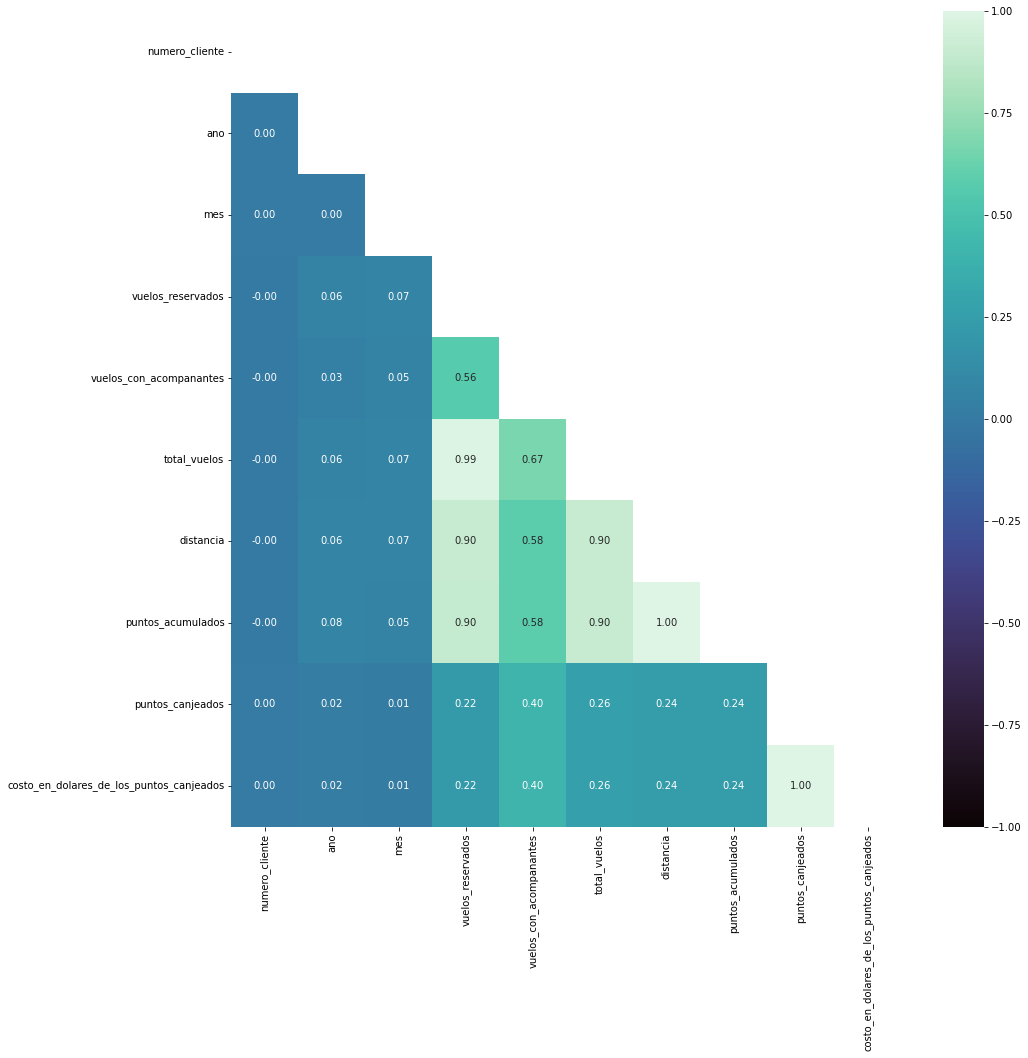

In [478]:
# Vamos a ponerlos en gráfico para verlo mejor
# establecemos el tamaño de la gráfica
plt.figure(figsize = (15, 15))

# creamos una matriz booleana de máscara
mask = np.triu(np.ones_like(df_correlaciones, dtype=bool))

# creamos un heatmap con la máscara
sns.heatmap(df_correlaciones, 
            annot = True, 
            fmt = ".2f", 
            cmap = "mako", 
            vmax = 1, 
            vmin = -1, 
            mask = mask); 

1. **Correlación Débil**:

   - El valor absoluto del coeficiente de correlación está cerca de 0.

   - Por lo general, se considera una correlación débil si el valor absoluto está por debajo de 0.3.

   - 

2. **Correlación Moderada**:

   - El valor absoluto del coeficiente de correlación está en el rango de 0.3 a 0.7.

   - Se considera una correlación moderada si el valor absoluto está en este rango.

3. **Correlación Fuerte**:

   - El valor absoluto del coeficiente de correlación es igual o superior a 0.7.

   - Se considera una correlación fuerte si el valor absoluto está en este rango.

In [479]:
# guardamos
df1.to_csv("Files/Customer Flight Activity_limpio.csv")